# OpenBB Functionality Research
## 3. Government
- **EU Yield Curve**
- **TIPS Yields**
- **Treasury Auctions**
- **Treasury Prices**
- **Treasury Rates**
- **US Yield Curve**
- **Yield Curve**


In [7]:
from openbb import obb

In [ ]:
# OpenBB Login
obb.account.login(email="email", password="password", remember_me=True)

# FRED API Key
obb.user.credentials.fred_api_key = "API-KEY"

Taking a deeper look at the government class, I am interested in the yield curve and how we can extract this

For this I will use FRED since I have an API key already and I will want to extract the US yield curve.
After a lot of trial and error and reading of documentation, I extracted the below:


- I removed the Index because I wanted better access to the date

In [9]:
import pandas as pd

us_yield_curve = obb.fixedincome.government.yield_curve(provider='fred', country='united_states')
df = us_yield_curve.to_df(index=False)
df

,date,maturity,rate
0,2024-11-07,month_1,0.0469
1,2024-11-07,month_3,0.0463
2,2024-11-07,month_6,0.0440
3,2024-11-07,year_1,0.0428
4,2024-11-07,year_2,0.0421
5,2024-11-07,year_3,0.0413
6,2024-11-07,year_5,0.0417
7,2024-11-07,year_7,0.0425
8,2024-11-07,year_10,0.0431
9,2024-11-07,year_20,0.0462


The output (after converting to a df for easier readability) has the date as an index and they state the maturities as a string of either the number of months or years.

I want the actual dates so we can build a simple yield curve

In [10]:
def get_maturity_date(maturity_str, start_date):
    """
    The data that is returned uses maturties in the form of month_1/year_1
    Because of this I will need to strip the string and convert it into a date
    """
    period = int(maturity_str.split('_')[1])
    if 'month' in maturity_str:
        return start_date + pd.DateOffset(months=period)
    elif 'year' in maturity_str:
        return start_date + pd.DateOffset(years=period)
    return start_date 

### Running the above gives me:

In [11]:
df["maturity"] = df.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df = df[['maturity','rate']] # Cleaning up the df
df

,maturity,rate
0,2024-12-07,0.0469
1,2025-02-07,0.0463
2,2025-05-07,0.0440
3,2025-11-07,0.0428
4,2026-11-07,0.0421
5,2027-11-07,0.0413
6,2029-11-07,0.0417
7,2031-11-07,0.0425
8,2034-11-07,0.0431
9,2044-11-07,0.0462


Later on I want to get to comparing yield curves with other goverments/countries, reading the doc string for the obb.fixedincome.government.yield_curve() shows that there are various provider, yield_types, countries and more that can be pulled

## Parameters
date : Union[date, str, None, List[Union[date, str, None]]]
A specific date to get data for. By default is the current data. Multiple comma separated items allowed for provider(s): ecb, econdb, federal_reserve, fmp, fred.

chart : bool
Whether to create a chart or not, by default False.

provider : Optional[Literal['ecb', 'econdb', 'federal_reserve', 'fmp', 'fred']]
The provider to use, by default None. If None, the priority list configured in the settings is used. Default priority: ecb, econdb, federal_reserve, fmp, fred.

rating : Literal['aaa', 'all_ratings']
The rating type, either 'aaa' or 'all_ratings'. (provider: ecb)

yield_curve_type : Union[Literal['spot_rate', 'instantaneous_forward', 'par_yield'], Literal['nominal', 'real', 'breakeven', 'treasury_minus_fed_funds', 'corporate_spot', 'corporate_par']]
The yield curve type. (provider: ecb); Yield curve type. Nominal and Real Rates are available daily, others are monthly. The closest date to the requested date will be returned. (provider: fred)

use_cache : bool
If true, cache the request for four hours. (provider: ecb, econdb)

country : Literal['australia', 'canada', 'china', 'hong_kong', 'india', 'japan', 'mexico', 'new_zealand', 'russia', 'saudi_arabia', 'singapore', 'south_africa', 'south_korea', 'taiwan', 'thailand', 'united_kingdom', 'united_states']
The country to get data. New Zealand, Mexico, Singapore, and Thailand have only monthly data. The nearest date to the requested one will be used. (provider: econdb)

Returns
OBBject
resultsList[YieldCurve] Serializable results. providerOptional[Literal['ecb', 'econdb', 'federal_reserve', 'fmp', 'fred']] Provider name. warnings]] List of warnings. chartOptional[Chart] Chart object. extraDict[str, Any] Extra info.

YieldCurve
date : Optional[date] The date of the data.

maturity : str Maturity length of the security.

rate : float The yield as a normalized percent (0.05 is 5%)

## Requesting a Japanese Curve from econdb

In [17]:
jap_yield_curve = obb.fixedincome.government.yield_curve(provider='econdb', country='japan')
df_j = jap_yield_curve.to_df(index=False)

df_j["maturity"] = df_j.apply(lambda row: get_maturity_date(row["maturity"], pd.to_datetime(row['date'])),axis=1)
df_j = df_j[['maturity','rate']] # Cleaning up the df
df_j

,maturity,rate
0,2025-10-23,0.00309
1,2026-10-23,0.00449
2,2027-10-23,0.00455
3,2028-10-23,0.00524
4,2029-10-23,0.00596
5,2030-10-23,0.00617
6,2031-10-23,0.00681
7,2032-10-23,0.00765
8,2033-10-23,0.00863
9,2034-10-23,0.00983


## Comparing US and Japanese curves

In [28]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['maturity'], y=df['rate'], mode='lines', name='United States'))
fig.add_trace(go.Scatter(x=df_j['maturity'], y=df_j['rate'], mode='lines', name='Japan'))

fig.update_layout(
    title="United States and Japanese Yield Comparison",
    xaxis_title="Maturity Date",
    yaxis_title="Rate",
    legend_title="Curves",
    template="plotly_dark"
)

fig.show()


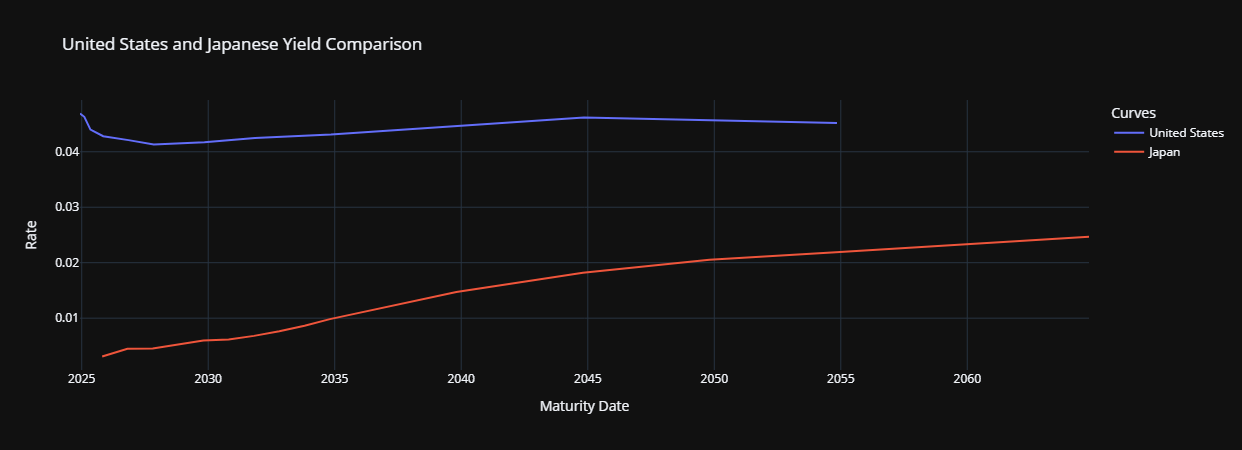